
# Module 2 - In this jupyter notebook, the seasonal T, ET, RET, NPP are calculated 

* Step 2a - Set up: Import modules/libraries, inport data, create output folder
* Step 2b - Defining function 
* Step 2c - Calculate seasonal T, ET, RET, ETp, NPP

**=====================================================================================================================**

![title](img/Fig2_1.png)

**=====================================================================================================================**

## Step 2a - Set up

## i) Import modules/libraries

In [1]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring

import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python 

# change the directory to where the modules are saved
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "Modules"))
from GIS_functions import GIS_function as gis

## ii) Import the input data:
* WaPOR data (T, AETI, REF, NPP), 
* Dates corresponding to the raster layer and 
* Start and end of cropseason and crop coefficient (Kc) of crop

## * Import raster (WaPOR) data

In [2]:
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"

# transpiration, evapotranspiration & interceptio and reference evapotranspiration
input_folderT = os.path.join(dir_proj, dir_data, "1_L2_T_filtered") 
input_fhsT = glob.glob(input_folderT + '\*.tif')  # glob.glob returns the list of files with their full path

input_folderET = os.path.join(dir_proj, dir_data, "1_L2_AETI_filtered") 
input_fhsET = glob.glob(input_folderET + '\*.tif')   

input_folderRET = os.path.join(dir_proj, dir_data, "1_L1_RET_filtered") 
input_fhsRET = glob.glob(input_folderRET + '\*.tif')

input_folderNPP = os.path.join(dir_proj, dir_data, "1_L2_NPP_filtered") 
input_fhsNPP = glob.glob(input_folderNPP + '\*.tif')

## ** Import the dates corresponding to the raster layers of WaPOR (cube code)

![title](img/Fig2_2.jpg), ![title](img/Fig2_3.png)

* Running the following cell activate the 'WaPOR' module that requires internet connection and takes longtime to download the the catalog 
* <span style='background :lightgreen' > **Run the cell only one time, if the latest date in the 'time_range' is updated.**
* <span style='background :pink' > While running this section for the first time, the the catalog info is saved in the working directory in excel file (e.g. df_availET.xlsx).
* <span style='background :pink' > Running the notebook for the second time should skip this cell, but run the next one (# read the df_avial from already saved excel under the Data) 

In [3]:
import os 
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "Modules"))
import WaPOR                                # API to interact with WaPOR portal
WaPOR.API.version = 2

# read the cube info (dataframe) from the cataloge 
cube_codeT   = 'L2_T_D' 
cube_codeET  = 'L2_AETI_D' 
cube_codeRET = 'L1_RET_D' 
cube_codeNPP = 'L2_NPP_D' 

time_range   = '2009-01-01,2019-12-31'

df_availT    = WaPOR.API.getAvailData(cube_codeT,   time_range)
df_availET   = WaPOR.API.getAvailData(cube_codeET,  time_range)
df_availRET  = WaPOR.API.getAvailData(cube_codeRET, time_range)
df_availNPP  = WaPOR.API.getAvailData(cube_codeNPP, time_range)

# save the dataframe to excel to access it offline
output_folder = os.path.join(os.path.split(os.getcwd())[0], "Data") 

df_availT.to_excel(os.path.join(output_folder,   'df_availT.xlsx'))
df_availET.to_excel(os.path.join(output_folder,  'df_availET.xlsx'))
df_availRET.to_excel(os.path.join(output_folder, 'df_availRET.xlsx'))
df_availNPP.to_excel(os.path.join(output_folder, 'df_availNPP.xlsx'))

# Get personaL WAPOR API Token by registering in the top right cornor of the page: wapor.apps.fao.org/home/1

Loading WaPOR catalog...


In [4]:
# read the df_avial from already saved excel 

time_range  = '2009-01-01,2019-12-31'

df_availT   = pd.read_excel('../data/df_availT.xlsx')
df_availET  = pd.read_excel('../data/df_availET.xlsx')
df_availRET = pd.read_excel('../data/df_availRET.xlsx')
df_availNPP = pd.read_excel('../data/df_availNPP.xlsx')

## *** Define and import the Start Of crop Season (SOS) and End Of crop Season (EOS)
* Edit the start and end of crop seasons **in the df_SOsEos.xlsx file in the data folder**
* You can add or delete rows depending on the number of seasons 

In [5]:
df_dates = pd.read_excel('../data/df_SosEos.xlsx')
df_dates

,Seasons,SOS,EOS
0,1,2009-10-01,2010-09-30
1,2,2010-10-01,2011-09-30
2,3,2011-10-01,2012-09-30
3,4,2012-10-01,2013-09-30
4,5,2013-10-01,2014-09-30
5,6,2014-10-01,2015-09-30
6,7,2015-10-01,2016-09-30
7,8,2016-10-01,2017-09-30
8,9,2017-10-01,2018-09-30
9,10,2018-10-01,2019-09-30


## **** Define and import the Kc per month
* Edit the **months** the corresponding **Kc** value in the order of start of crop season (inital stage) to end of crop season (late-season stage) **in the df_Kc.xlsx file in the data folder**
* The rows should be for months within the duration of the crop season 
* The figure below shows the Kc curve of a sugarcane, given as example
![title](img/Fig3_2.PNG)

In [6]:
df_kc = pd.read_excel('../data/df_Kc.xlsx')
df_kc 

,Months,Kc,Crops stage
0,October,0.40000,Initial
1,November,0.61250,NaN
2,December,1.03750,NaN
3,January,1.25000,NaN
4,February,1.25000,NaN
5,March,1.25000,NaN
6,April,1.25000,NaN
7,May,1.25000,NaN
8,June,1.25000,NaN
9,July,1.08335,NaN


## iii) Output folder: Make one or connect to the existing one

In [7]:
# the directory of the output folder
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"
output_folderT           = os.path.join(dir_proj, dir_data, "2L2_T_season") 
output_folderET          = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
output_folderRET         = os.path.join(dir_proj, dir_data, "2L1_RET_season") 
output_folderRET_month   = os.path.join(dir_proj, dir_data, "2L1_RET_month")    
output_folderETp         = os.path.join(dir_proj, dir_data, "2L1_ETp_season")    #ETp (= ETc) =Kc*REF
output_folderNPP         = os.path.join(dir_proj, dir_data, "2L2_NPP_season") 

# Make one if the folder does not exit
if not os.path.exists(output_folderT):
    os.makedirs(output_folderT) 
if not os.path.exists(output_folderET):
    os.makedirs(output_folderET) 
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET)  
if not os.path.exists(output_folderRET_month):
    os.makedirs(output_folderRET_month)
if not os.path.exists(output_folderETp):
    os.makedirs(output_folderETp) 
if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP) 

## Step 2b - Define function - the function that add rasters between two dates

In [8]:
# summation of raster between two dates
def SumSeason(input_fhs, saveSum, sowing_date, harvesting_date, df_avail):
    """
    Add raster files (input_fhs) between sowing_date and harvesting_date.

    IHE Delft 2019
    Authors: a.chukalla@un-ihe.org
    @author: Abebe Chukalla

    Parameters
    ----------
    input_fhs : raster file
        Files to be added.
    saveSum : folder name
        Folder name where the sum to be saved.
    sowing_date : date in yyyy-mm-dd format
        Starting date of crop growth.
    harvesting_date : date in yyyy-mm-dd format
        Harvesting date of crop.
    df_avail : cube_code of the raster
        Helps to read the date of each raster file.
        
    Returns
    -------
    Sums: array
        Seasonal, sum of the raster files.
    """
    period_dates = pd.date_range(sowing_date, harvesting_date, freq='D')  # generate dates b/n sowing and harvesting dates
    period_fhs   = []

    # collect the rasters if they are within sowing and harvesting date
    for in_fh in input_fhs:
        # get raster id from file name
        raster_id = os.path.split(in_fh)[-1].split('.')[0]               
        # get raster info using raster id
        raster_info = df_avail.loc[df_avail['raster_id']==raster_id]      # the time_code corresponding to raster id
        # get start and end date of raster
        raster_startdate = raster_info['time_code'].iloc[0].split(',')[0] 
        raster_startdate = re.sub(r"[[)]", "", raster_startdate)          
        raster_enddate = raster_info['time_code'].iloc[0].split(',')[-1]  
        raster_enddate = re.sub(r"[[)]", "", raster_enddate)               
        # check if raster belong to period
        if ((raster_startdate in period_dates) or (raster_enddate in period_dates)):
            period_fhs.append(in_fh)

    # add the layers between the sowing and harvesting dates
    period_fhs
    period_fh = period_fhs[0]
    Sums = 0
    for period_fh in period_fhs:
        Sum = gis.OpenAsArray(period_fh, nan_values=True)
        Sums += Sum
           
    # save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(saveSum, raster_id.split('_')[1] + '_' + str(sowing_date) + '_to_' + str(harvesting_date) + '.tif')        
    gis.CreateGeoTiff(out_fh, Sums, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
        
    return Sums  

## Step 2c - Calculate seasonal T, ET, RET, ETp, NPP

## i) Calculate seasonal transpiration (T)

the mean & SD for  2009-10-01/2010-09-30 = 1127.5 & 137.4


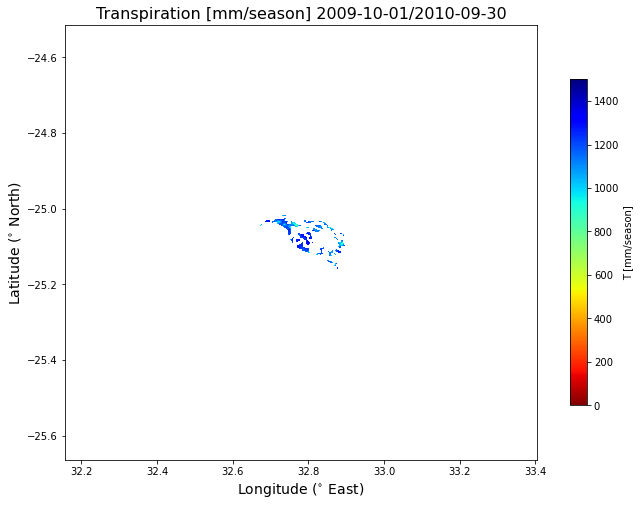

the mean & SD for  2010-10-01/2011-09-30 = 1189.6 & 140.6


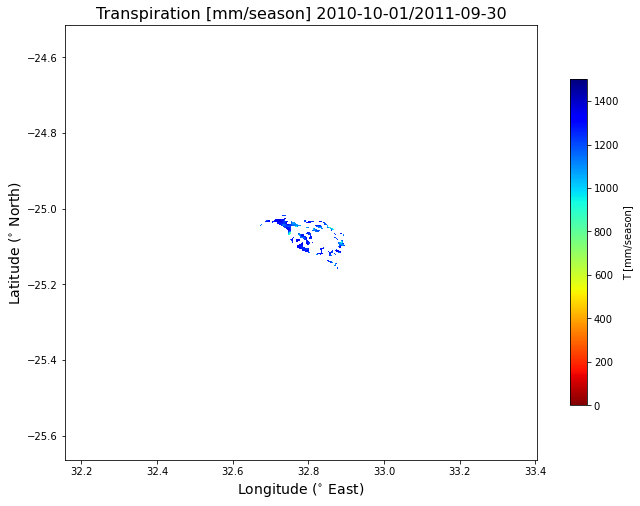

the mean & SD for  2011-10-01/2012-09-30 = 1140.5 & 157.1


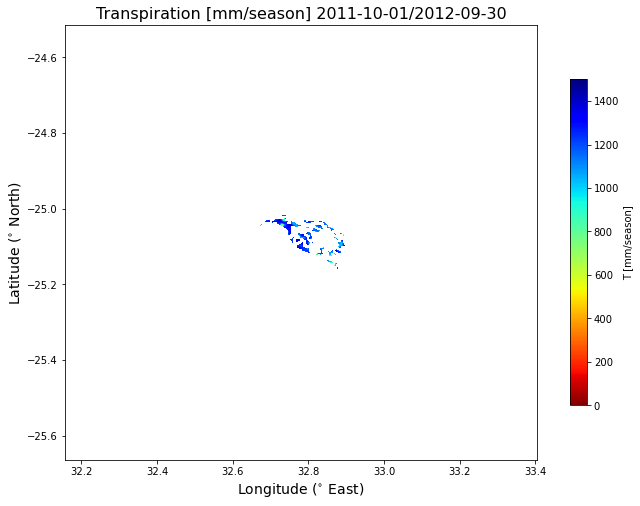

the mean & SD for  2012-10-01/2013-09-30 = 1146.8 & 136.1


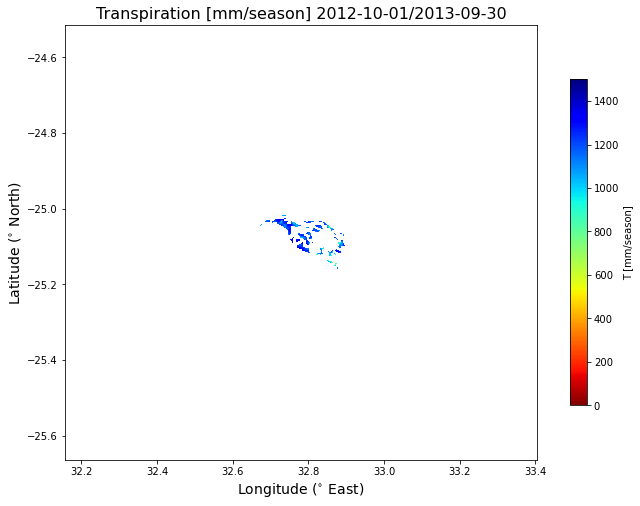

the mean & SD for  2013-10-01/2014-09-30 = 1210.4 & 111.6


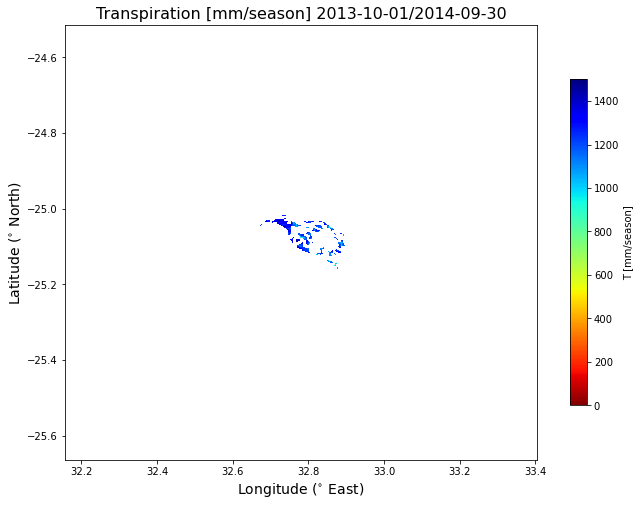

the mean & SD for  2014-10-01/2015-09-30 = 1140.3 & 174.1


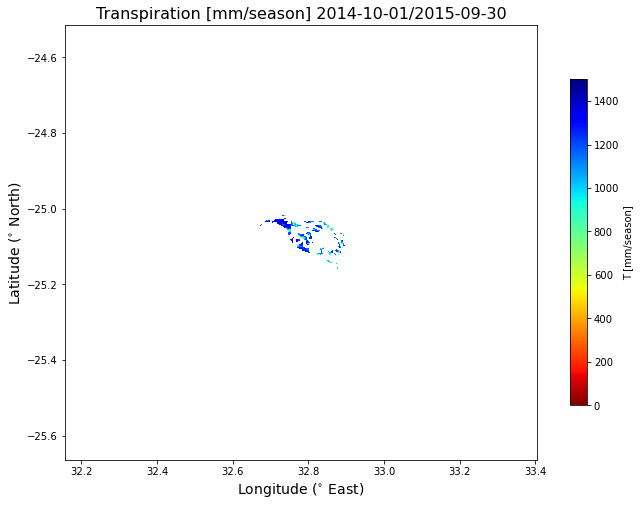

the mean & SD for  2015-10-01/2016-09-30 = 1096.5 & 197.3


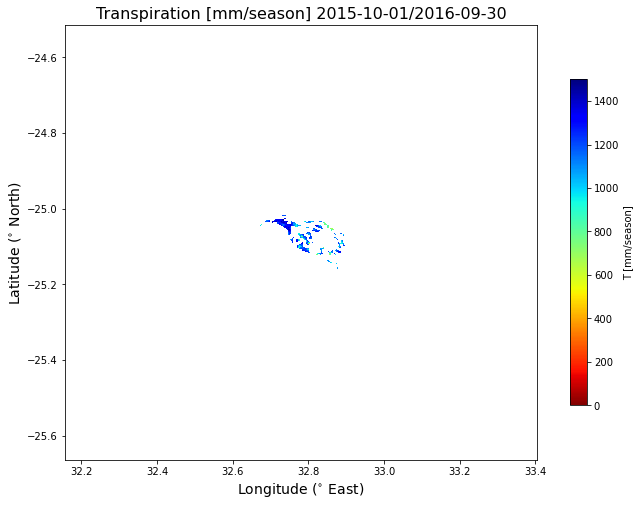

the mean & SD for  2016-10-01/2017-09-30 = 1142.2 & 123.3


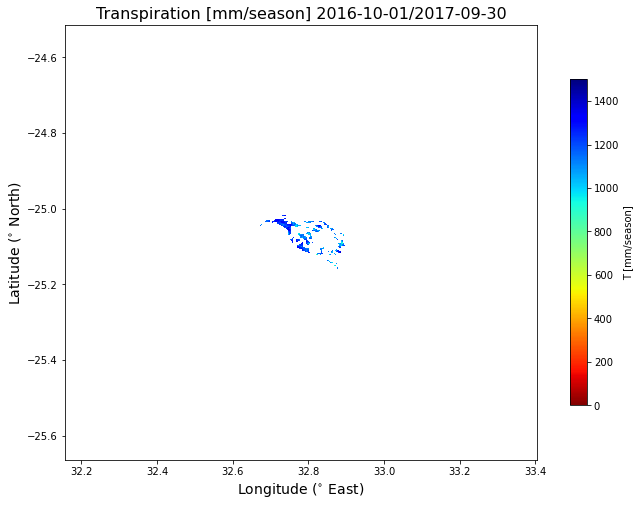

the mean & SD for  2017-10-01/2018-09-30 = 1180.7 & 152.0


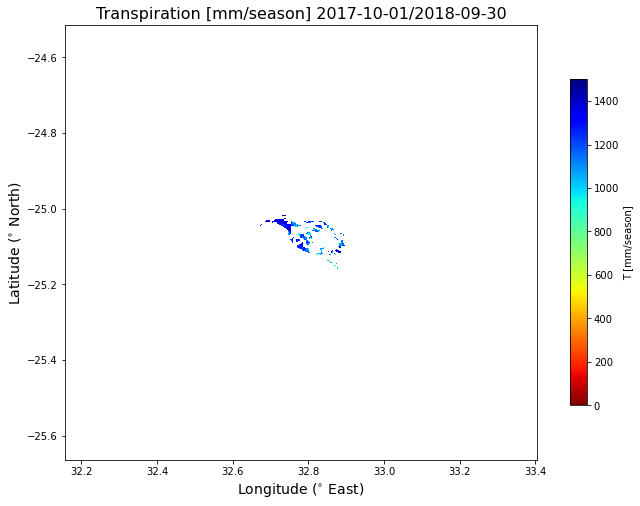

the mean & SD for  2018-10-01/2019-09-30 = 1142.1 & 161.2


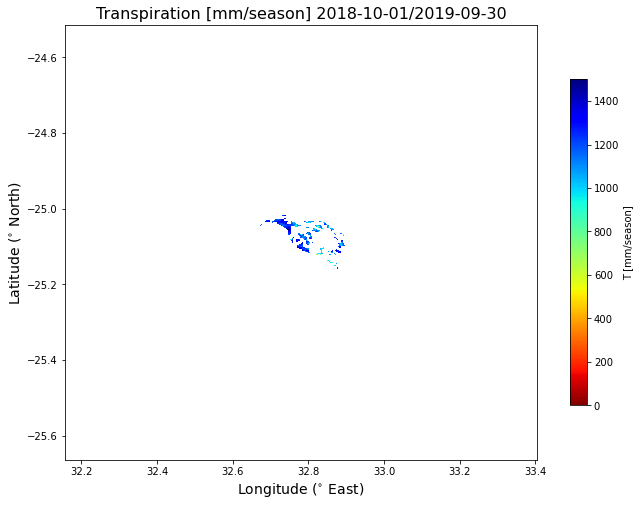

In [9]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsT[0]  

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:  
    # calculate the seasonal value and save in output_folderT
    seasonal = SumSeason(input_fhsT, output_folderT, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availT)
   
    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='T [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Transpiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.clim(0,1500)
    plt.show ()
    
    i += 1
    ;

## ii) Calculate seasonal evapotranspiration

the mean & SD for  2009-10-01/2010-09-30 = 1328.7 & 133.4


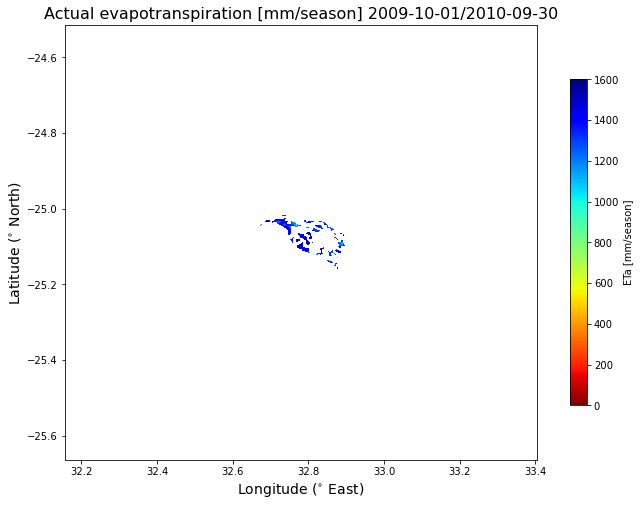

the mean & SD for  2010-10-01/2011-09-30 = 1422.4 & 136.9


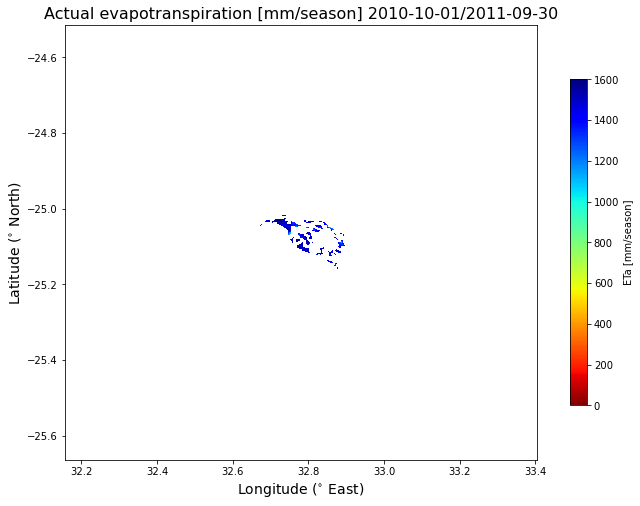

the mean & SD for  2011-10-01/2012-09-30 = 1338.8 & 151.3


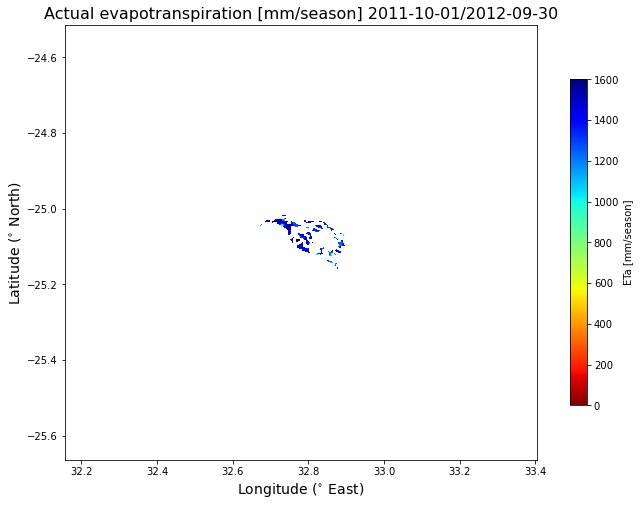

the mean & SD for  2012-10-01/2013-09-30 = 1351.4 & 134.8


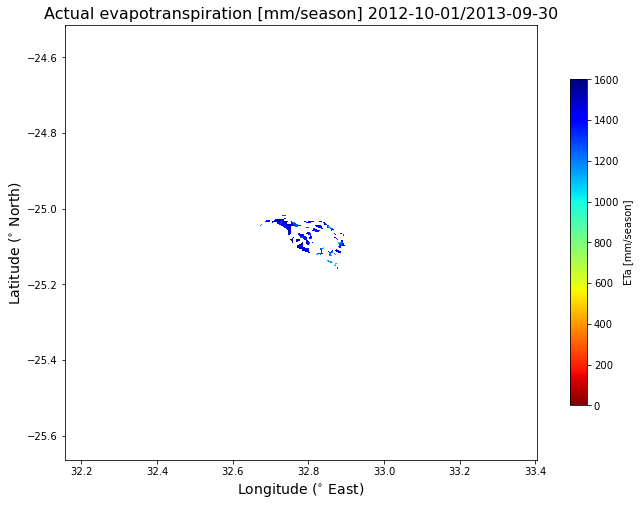

the mean & SD for  2013-10-01/2014-09-30 = 1433.1 & 111.5


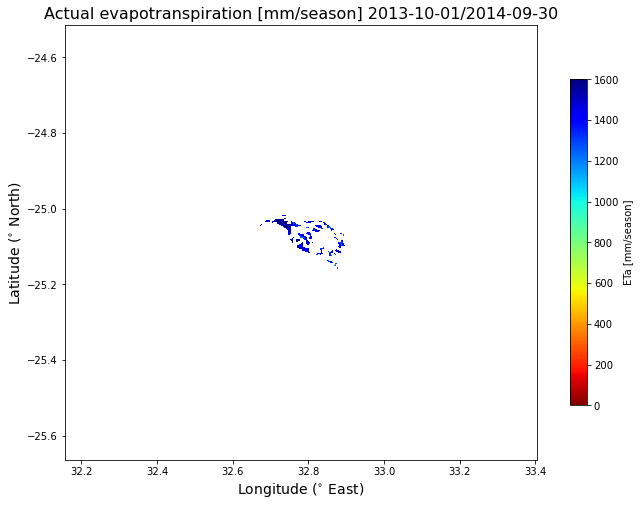

the mean & SD for  2014-10-01/2015-09-30 = 1377.1 & 162.9


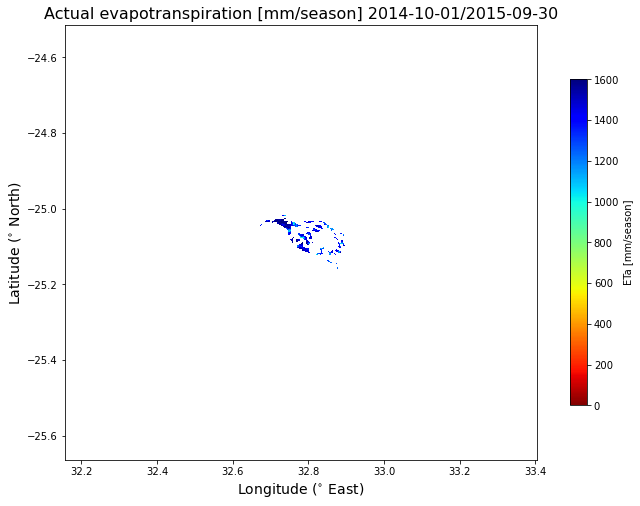

the mean & SD for  2015-10-01/2016-09-30 = 1318.6 & 196.9


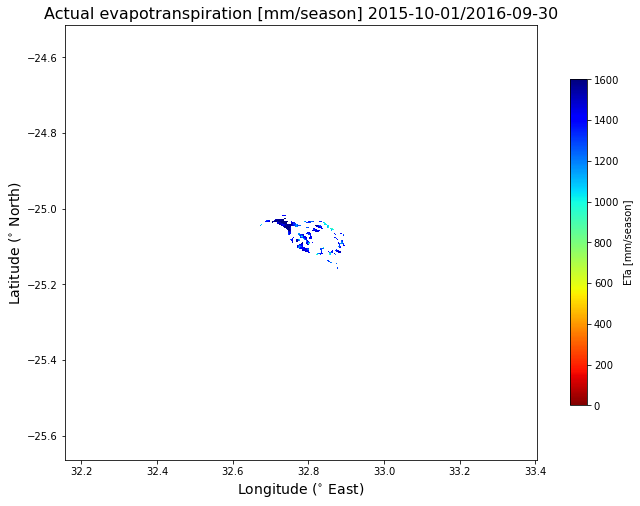

the mean & SD for  2016-10-01/2017-09-30 = 1374.2 & 120.6


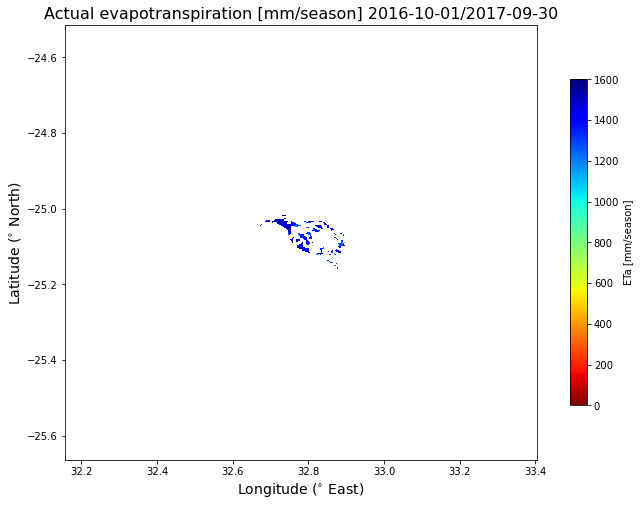

the mean & SD for  2017-10-01/2018-09-30 = 1397.7 & 148.5


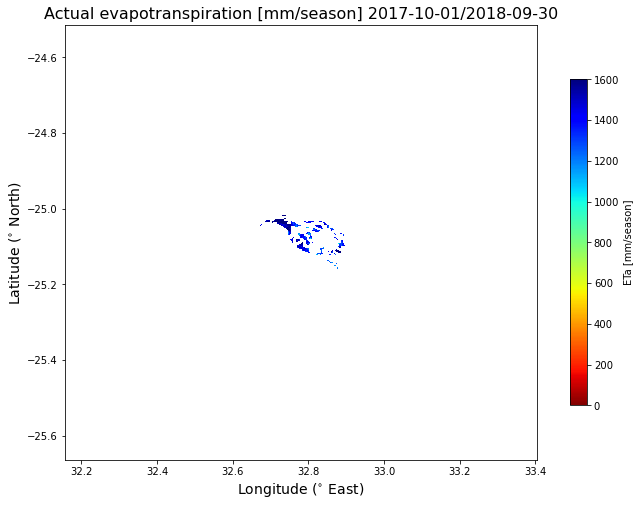

the mean & SD for  2018-10-01/2019-09-30 = 1380.1 & 157.4


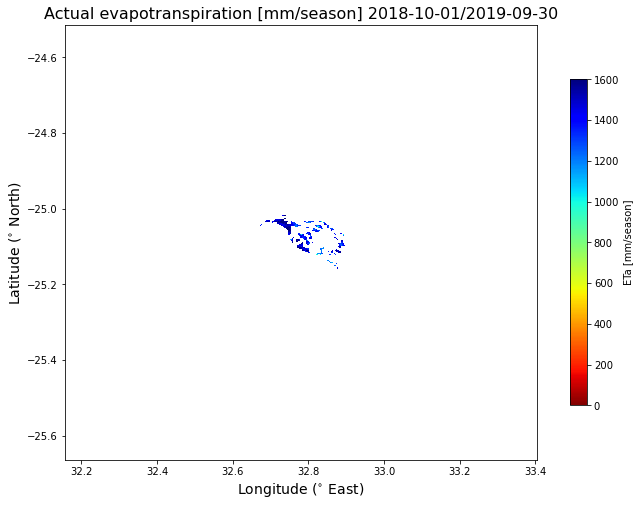

In [10]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]    

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of seasonn
                
i = 0
while i < length:    
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsET, output_folderET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availET)
    
    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ETa [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Actual evapotranspiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.clim(0,1600)
    plt.show()

    i += 1
    ;

## iii) Calculate seasonal Reference Evapotranspiration(RET)

the mean & SD for  2009-10-01/2010-09-30 = 1796.0 & 28.9


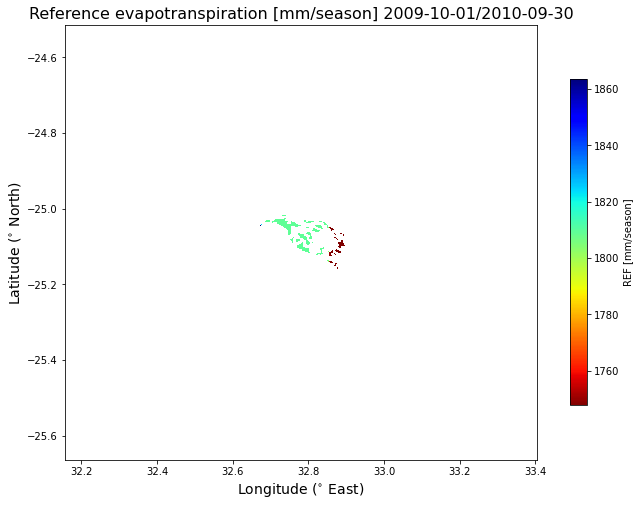

the mean & SD for  2010-10-01/2011-09-30 = 1906.7 & 33.6


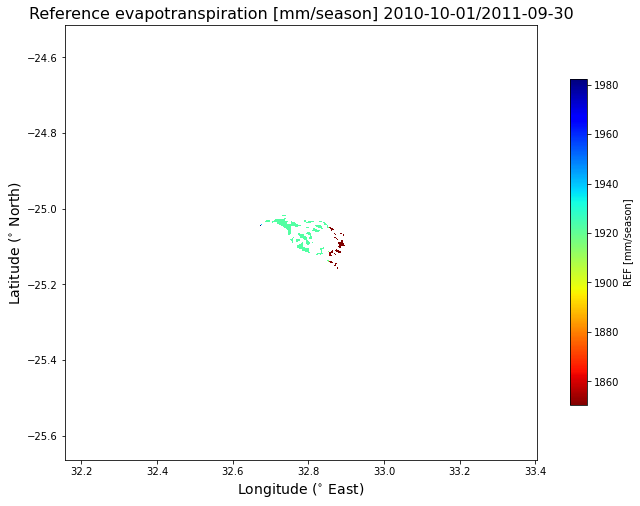

the mean & SD for  2011-10-01/2012-09-30 = 1850.3 & 34.2


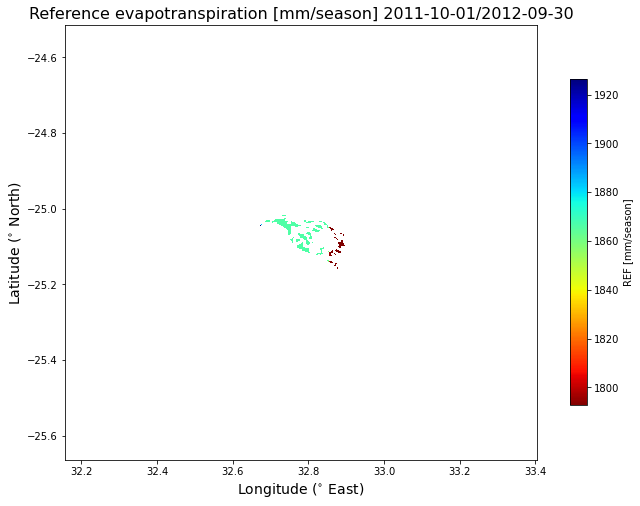

the mean & SD for  2012-10-01/2013-09-30 = 1796.1 & 31.5


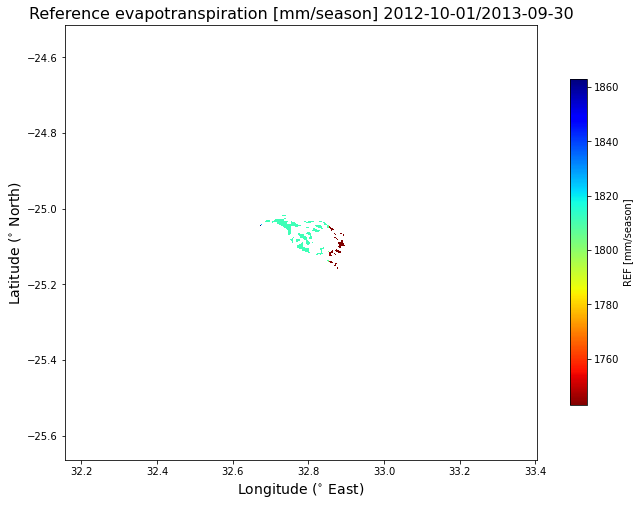

the mean & SD for  2013-10-01/2014-09-30 = 1877.6 & 37.6


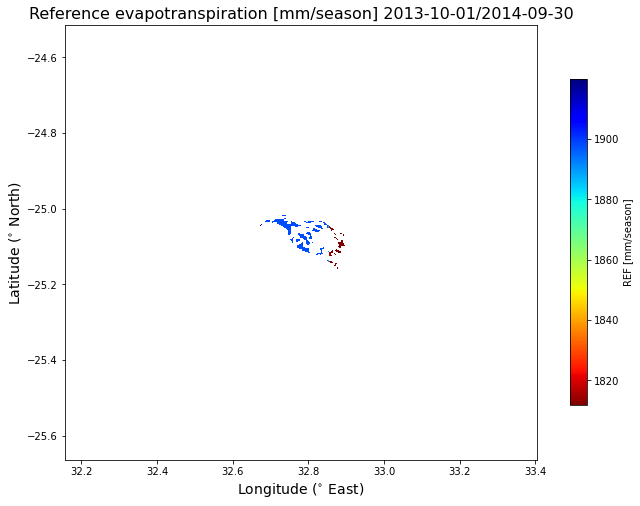

the mean & SD for  2014-10-01/2015-09-30 = 1893.2 & 37.8


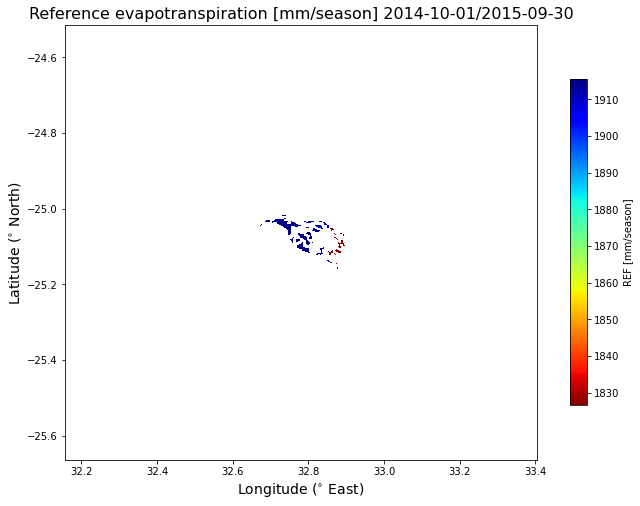

the mean & SD for  2015-10-01/2016-09-30 = 2037.6 & 63.7


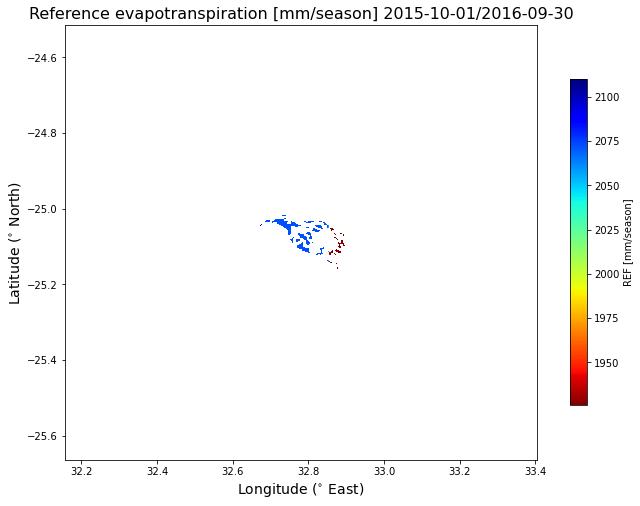

the mean & SD for  2016-10-01/2017-09-30 = 1844.7 & 30.7


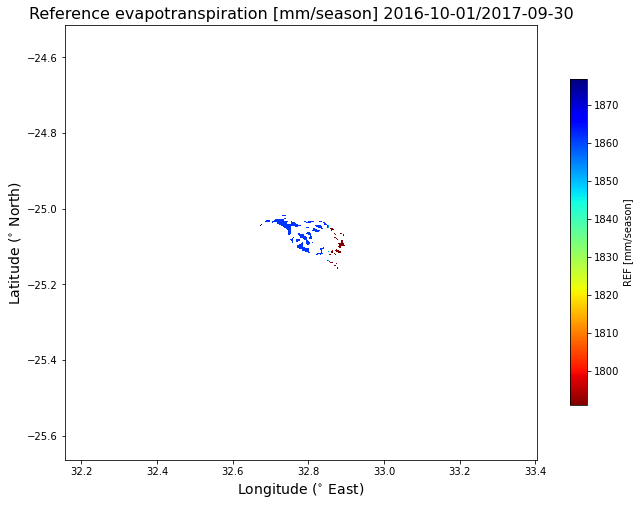

the mean & SD for  2017-10-01/2018-09-30 = 1940.9 & 20.7


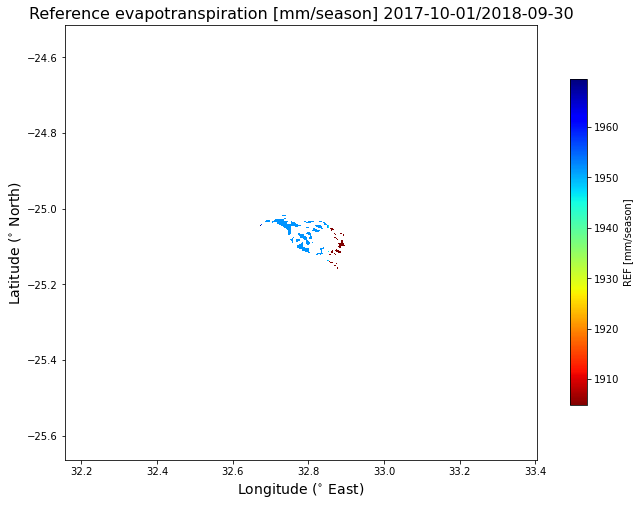

the mean & SD for  2018-10-01/2019-09-30 = 2053.2 & 28.1


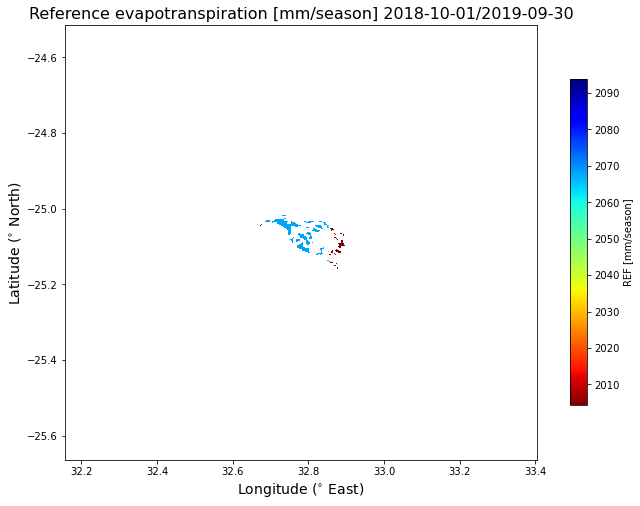

In [11]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:    
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsRET, output_folderRET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availRET)

    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))
    
    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='REF [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Reference evapotranspiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.show ()

    i += 1
    ;

## iv) Calculate seasonal ETp(ETc) = Kc*RET

Monthly ETo, ETc in mm/month and Kc[-] in  2009
2009 October 232.7 93.1 0.4
2009 November 237.0 145.2 0.6125
2009 December 245.2 254.4 1.0375
2010 January 261.0 326.3 1.25
2010 February 216.2 270.2 1.25
2010 March 193.5 241.8 1.25
2010 April 147.3 184.1 1.25
2010 May 136.3 170.3 1.25
2010 June 132.6 165.8 1.25
2010 July 123.9 134.2 1.08335
2010 August 165.9 165.9 1.0
2010 September 233.7 194.7 0.833
The mean seasonal ETc [mm] in  2010  is  2346.0


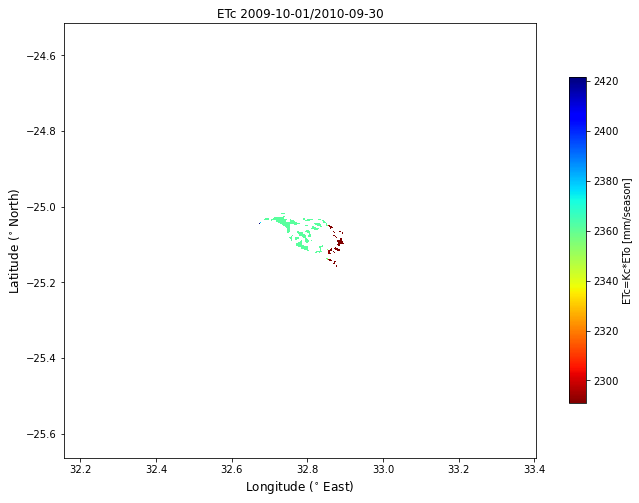

Monthly ETo, ETc in mm/month and Kc[-] in  2010
2010 October 261.3 104.5 0.4
2010 November 257.4 157.7 0.6125
2010 December 235.0 243.8 1.0375
2011 January 219.8 274.7 1.25
2011 February 217.0 271.2 1.25
2011 March 224.1 280.1 1.25
2011 April 193.6 241.9 1.25
2011 May 183.2 229.0 1.25
2011 June 172.1 215.1 1.25
2011 July 145.7 157.8 1.08335
2011 August 163.2 163.2 1.0
2011 September 229.8 191.4 0.833
The mean seasonal ETc [mm] in  2011  is  2530.6


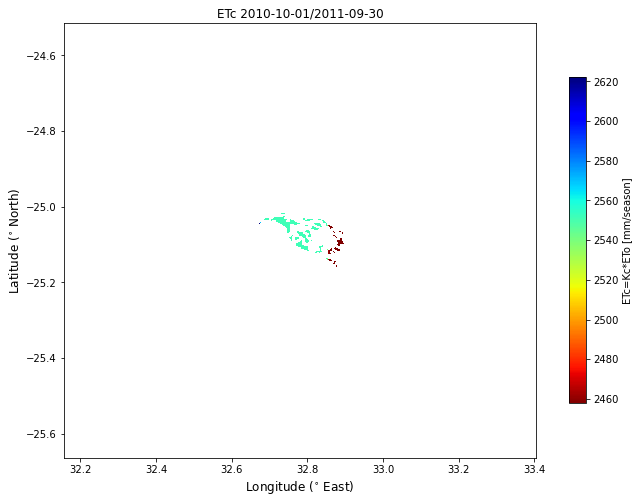

Monthly ETo, ETc in mm/month and Kc[-] in  2011
2011 October 217.3 86.9 0.4
2011 November 243.0 148.9 0.6125
2011 December 230.6 239.3 1.0375
2012 January 245.8 307.3 1.25
2012 February 216.5 270.6 1.25
2012 March 204.4 255.5 1.25
2012 April 177.0 221.2 1.25
2012 May 156.2 195.2 1.25
2012 June 147.0 183.7 1.25
2012 July 145.5 157.6 1.08335
2012 August 195.3 195.3 1.0
2012 September 220.1 183.4 0.833
The mean seasonal ETc [mm] in  2012  is  2444.9


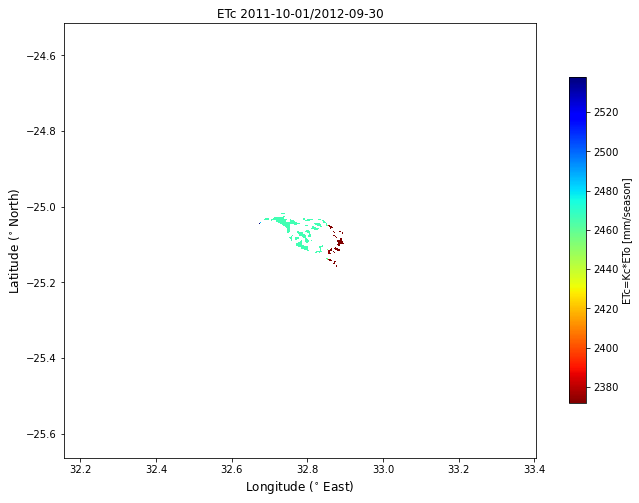

Monthly ETo, ETc in mm/month and Kc[-] in  2012
2012 October 230.2 92.1 0.4
2012 November 232.6 142.4 0.6125
2012 December 244.6 253.7 1.0375
2013 January 221.5 276.9 1.25
2013 February 203.3 254.2 1.25
2013 March 192.6 240.8 1.25
2013 April 168.8 211.0 1.25
2013 May 146.8 183.5 1.25
2013 June 145.6 182.0 1.25
2013 July 135.8 147.1 1.08335
2013 August 180.1 180.1 1.0
2013 September 236.4 196.9 0.833
The mean seasonal ETc [mm] in  2013  is  2360.7


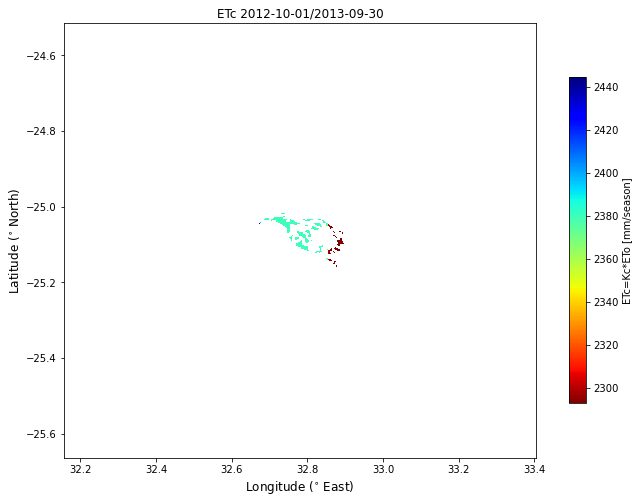

Monthly ETo, ETc in mm/month and Kc[-] in  2013
2013 October 221.4 88.5 0.4
2013 November 239.2 146.5 0.6125
2013 December 217.3 225.5 1.0375
2014 January 236.3 295.4 1.25
2014 February 216.9 271.1 1.25
2014 March 189.5 236.8 1.25
2014 April 178.9 223.7 1.25
2014 May 175.0 218.8 1.25
2014 June 166.2 207.7 1.25
2014 July 158.9 172.1 1.08335
2014 August 189.6 189.6 1.0
2014 September 243.9 203.2 0.833
The mean seasonal ETc [mm] in  2014  is  2478.8


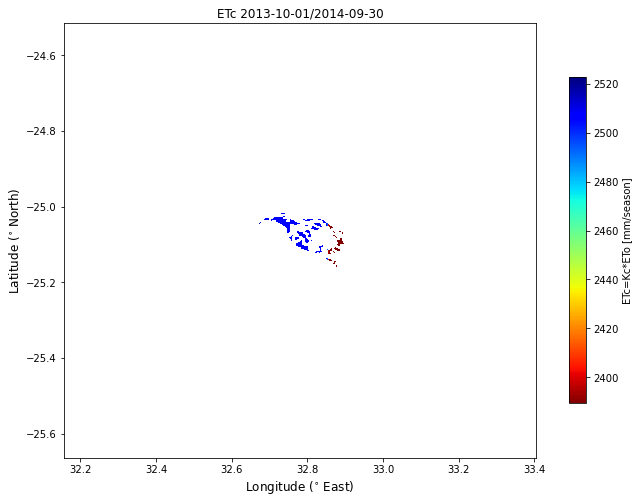

Monthly ETo, ETc in mm/month and Kc[-] in  2014
2014 October 232.5 93.0 0.4
2014 November 227.8 139.5 0.6125
2014 December 233.0 241.7 1.0375
2015 January 250.1 312.6 1.25
2015 February 243.1 303.9 1.25
2015 March 233.5 291.9 1.25
2015 April 188.0 235.1 1.25
2015 May 166.8 208.6 1.25
2015 June 155.5 194.4 1.25
2015 July 147.5 159.8 1.08335
2015 August 182.8 182.8 1.0
2015 September 212.3 176.8 0.833
The mean seasonal ETc [mm] in  2015  is  2540.2


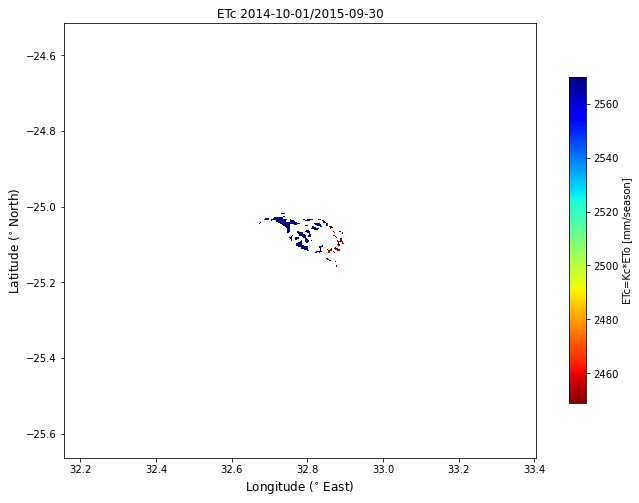

Monthly ETo, ETc in mm/month and Kc[-] in  2015
2015 October 271.2 108.5 0.4
2015 November 281.5 172.4 0.6125
2015 December 286.8 297.5 1.0375
2016 January 278.6 348.3 1.25
2016 February 253.5 316.9 1.25
2016 March 216.5 270.7 1.25
2016 April 216.7 270.8 1.25
2016 May 161.5 201.9 1.25
2016 June 133.1 166.4 1.25
2016 July 131.1 142.0 1.08335
2016 August 177.3 177.3 1.0
2016 September 230.1 191.7 0.833
The mean seasonal ETc [mm] in  2016  is  2664.6


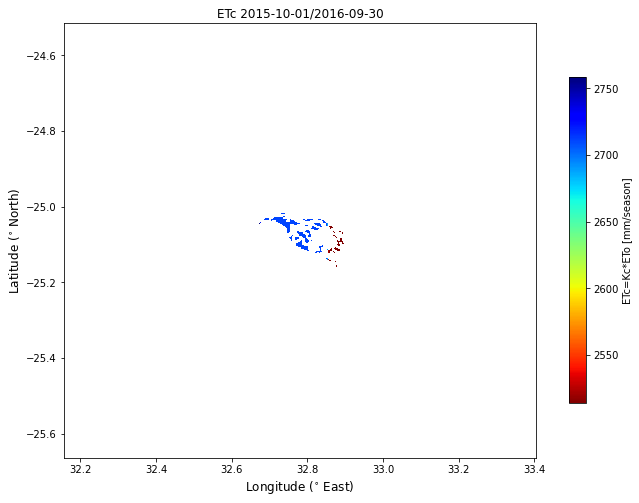

Monthly ETo, ETc in mm/month and Kc[-] in  2016
2016 October 245.9 98.4 0.4
2016 November 247.5 151.6 0.6125
2016 December 249.0 258.4 1.0375
2017 January 218.9 273.7 1.25
2017 February 209.9 262.4 1.25
2017 March 192.1 240.1 1.25
2017 April 181.9 227.4 1.25
2017 May 146.5 183.1 1.25
2017 June 143.8 179.8 1.25
2017 July 145.7 157.9 1.08335
2017 August 175.2 175.2 1.0
2017 September 220.4 183.6 0.833
The mean seasonal ETc [mm] in  2017  is  2391.6


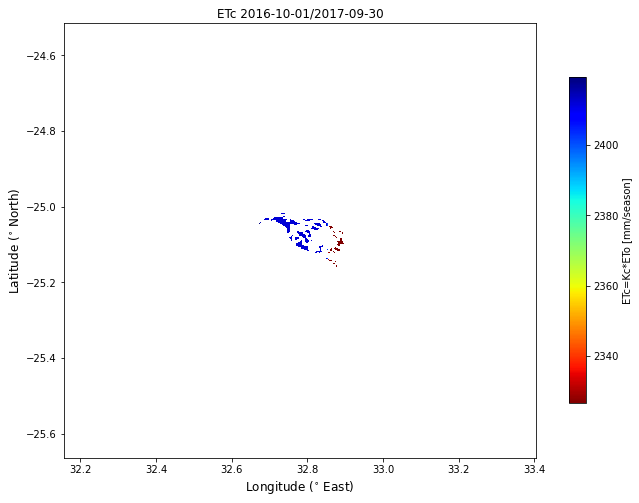

Monthly ETo, ETc in mm/month and Kc[-] in  2017
2017 October 239.7 95.9 0.4
2017 November 259.2 158.8 0.6125
2017 December 247.9 257.2 1.0375
2018 January 281.0 351.3 1.25
2018 February 222.0 277.5 1.25
2018 March 196.4 245.5 1.25
2018 April 180.6 225.8 1.25
2018 May 152.3 190.3 1.25
2018 June 149.9 187.4 1.25
2018 July 138.8 150.4 1.08335
2018 August 188.3 188.3 1.0
2018 September 253.2 210.9 0.833
The mean seasonal ETc [mm] in  2018  is  2539.1


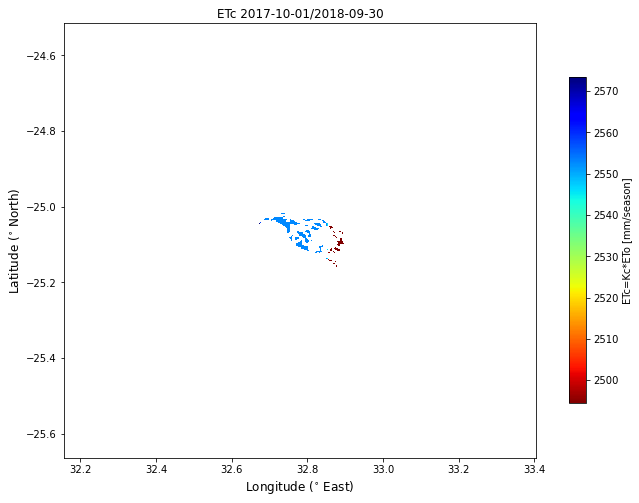

Monthly ETo, ETc in mm/month and Kc[-] in  2018
2018 October 239.8 95.9 0.4
2018 November 272.3 166.8 0.6125
2018 December 302.9 314.3 1.0375
2019 January 277.0 346.2 1.25
2019 February 248.8 310.9 1.25
2019 March 232.0 290.0 1.25
2019 April 195.3 244.1 1.25
2019 May 161.6 202.1 1.25
2019 June 134.4 168.0 1.25
2019 July 174.6 189.2 1.08335
2019 August 208.0 208.0 1.0
2019 September 225.1 187.5 0.833
The mean seasonal ETc [mm] in  2019  is  2723.0


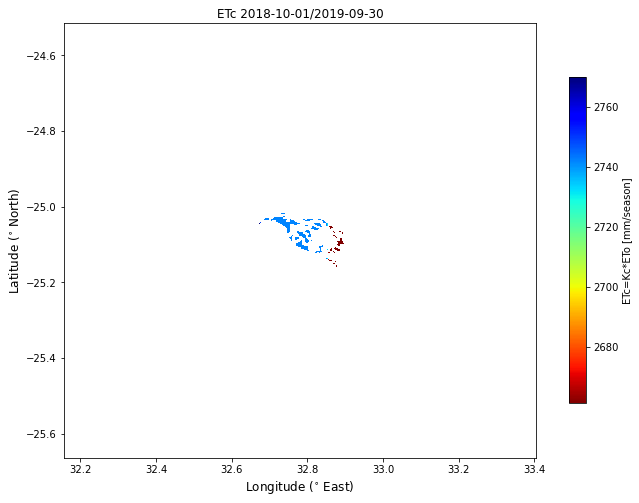

In [12]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    date_s  = df_dates.SOS[i].date()   # the starting date of the season (SOS)
    #ETc_total[i] = 0
    print ('Monthly ETo, ETc in mm/month and Kc[-] in ', date_s.year)
    seasonal = 0
    while date_s < df_dates.EOS[i].date():    # loop in the range of SOS and EOS of the active season 'i' 
        # Increment by a month
        days    = calendar.monthrange(date_s.year,date_s.month)[1] # Number of days in the active month
        date_e  = date_s+datetime.timedelta(days=days-1)           # The end date of the active month
        
        m = date_s.strftime('%B')         # identify the name of the active month
        kc_m =df_kc.loc[df_kc["Months"] == m, 'Kc'].item()  # identify the kc value corresponding to a month
           
        # calculate the monthly value and save in output_folder
        ET0 = SumSeason(input_fhsRET, output_folderRET_month, date_s, date_e, df_availRET) # adding reference ET in the active month
        ETc = kc_m*ET0    # calculate monthly ETP (ETc)

        print (date_s.year, m, np.nanmean(ET0).round(1), np.nanmean(ETc).round(1), kc_m)
        date_s  = date_e+datetime.timedelta(days=1)   # First day of the next month
        seasonal+= ETc
    
    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderETp, 'ETc_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonal, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean seasonal ETc [mm] in ', date_s.year, ' is ', np.nanmean(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ETc=Kc*ETo [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('ETc ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=12)
    plt.clim()
    plt.show ()

    i += 1
    ;

## v) Calculate seasonal Net Primary Production (NPP)

the mean & SD for  2009-10-01/2010-09-30 = 1014.6 & 87.1


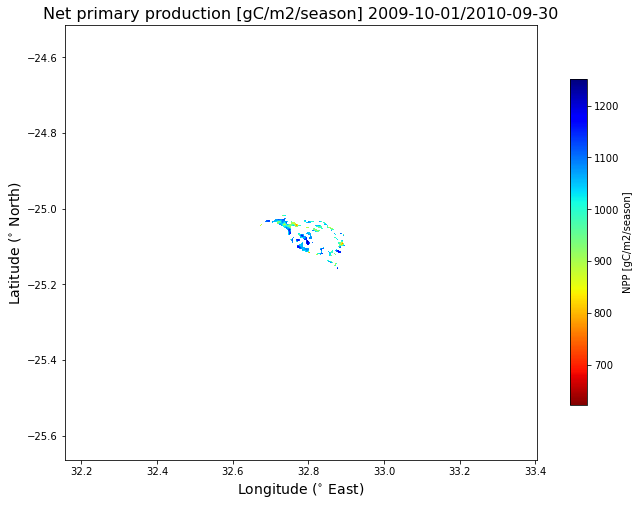

the mean & SD for  2010-10-01/2011-09-30 = 1035.1 & 89.6


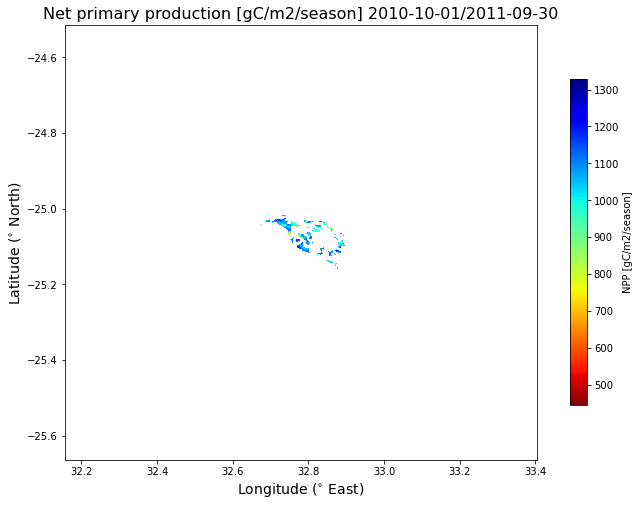

the mean & SD for  2011-10-01/2012-09-30 = 1090.9 & 111.8


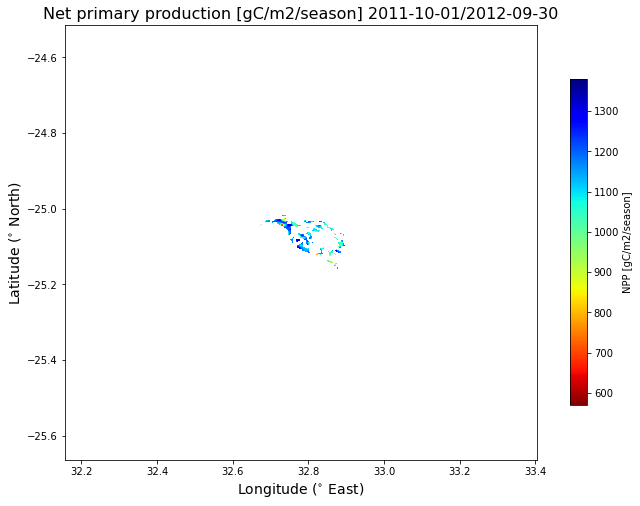

the mean & SD for  2012-10-01/2013-09-30 = 1149.3 & 111.6


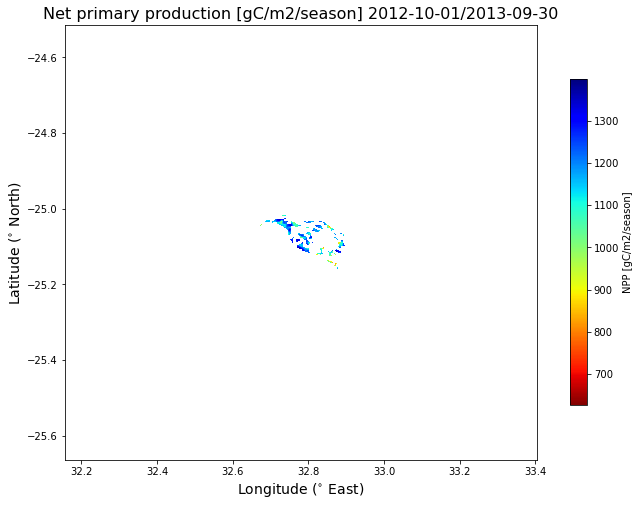

the mean & SD for  2013-10-01/2014-09-30 = 1131.3 & 96.9


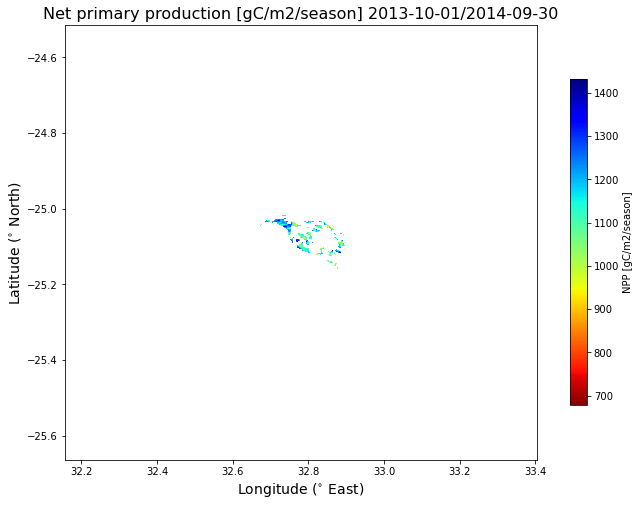

the mean & SD for  2014-10-01/2015-09-30 = 1014.8 & 127.7


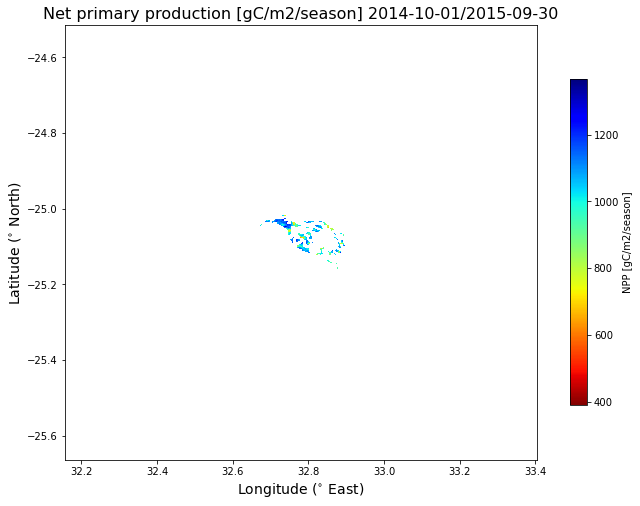

the mean & SD for  2015-10-01/2016-09-30 = 919.8 & 122.3


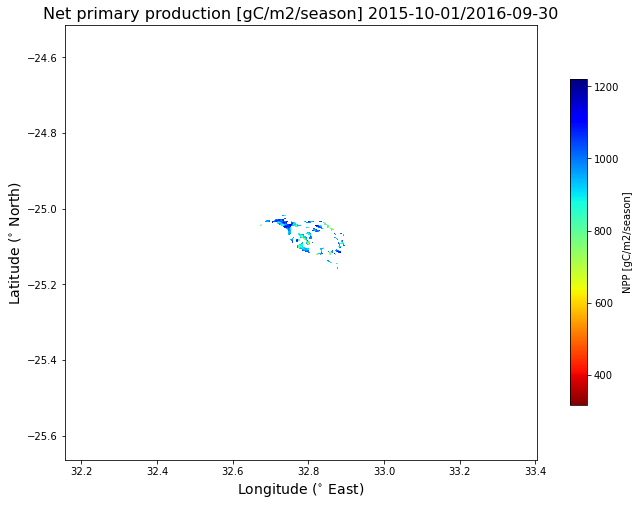

the mean & SD for  2016-10-01/2017-09-30 = 1065.0 & 101.2


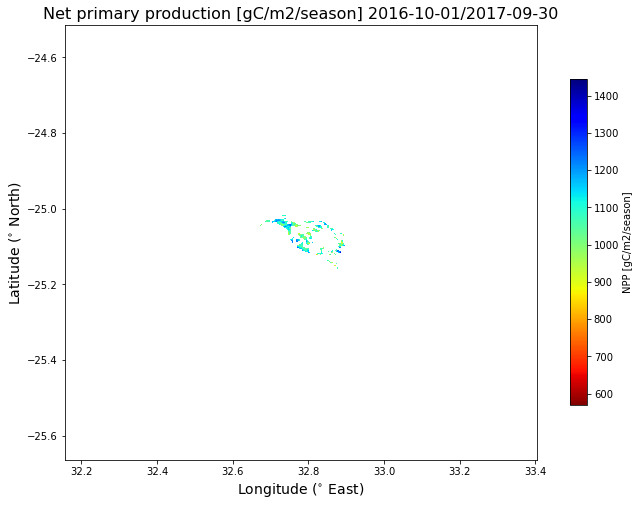

the mean & SD for  2017-10-01/2018-09-30 = 1080.5 & 113.7


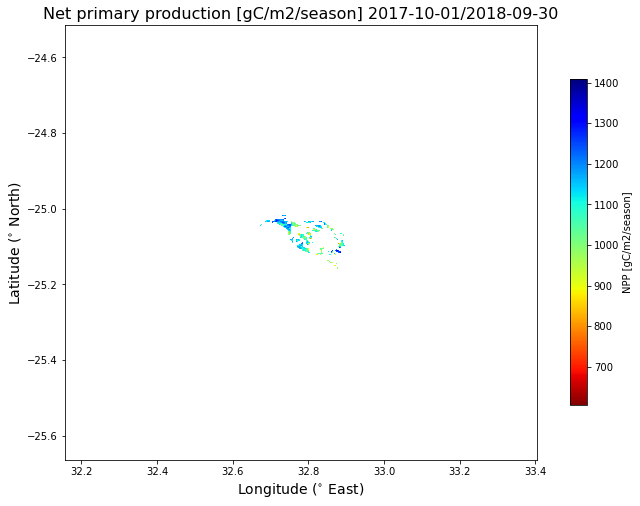

the mean & SD for  2018-10-01/2019-09-30 = 965.4 & 112.5


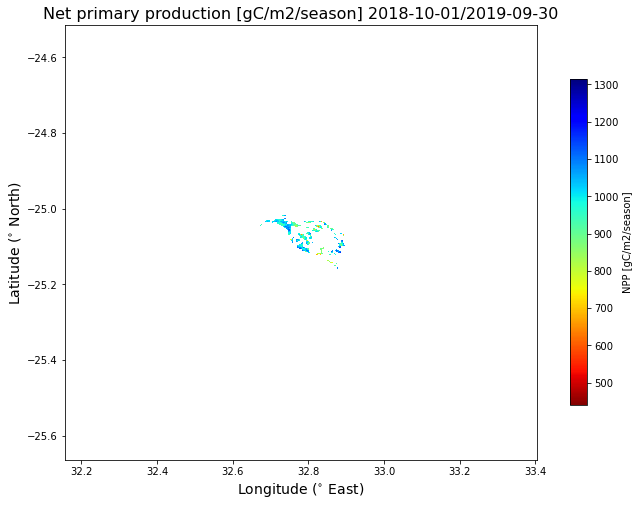

In [13]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsNPP[0]

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsNPP, output_folderNPP, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availNPP)

    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))
    
    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m2/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Net primary production [gC/m2/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.show ()
    
    i += 1 
    ;